In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pickle
import os

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
%matplotlib inline

## Part 1: Data Preparation 

In [2]:
future_date = 14

Read CSV data from Github.

In [3]:
confirmed_raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed_raw['Province/State'].fillna('-', inplace=True)
deaths_raw['Province/State'].fillna('-', inplace=True)
recoveries_raw['Province/State'].fillna('-', inplace=True)

recoveries_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
0,-,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,32,32,32,32,40,43,54,99,112,131
1,-,Albania,41.1533,20.1683,0,0,0,0,0,0,...,182,197,217,232,248,251,277,283,302,314
2,-,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,405,460,591,601,691,708,783,846,894,1047
3,-,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,71,71,128,128,128,169,169,191,205,235
4,-,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,4,4,4,5,5,5,5,6,6


In [4]:
indexes = ['Province/State', 'Country/Region']
geo_loc = ['Lat', 'Long']
dates = confirmed_raw.columns[4:]
non_dates = [e for e in confirmed_raw.columns if e not in dates]
dates

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20',
       '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20',
       '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20',
       '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20',
       '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20',
       '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20',
       '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20',
       '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20',
       '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20',
       '3/31/20', '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20',
       '4/7/20', '4/8/20', '4/9/20', '4/10/20', '4/11/20', '4/12/20',
       '4/13/20', '4/14/20', '4/15

In [5]:
# confirmed_raw.set_index(indexes)
# deaths_raw.set_index(indexes)
# recoveries_raw.set_index(indexes)

print(confirmed_raw.shape)
print(deaths_raw.shape)
print(recoveries_raw.shape)

(264, 93)
(264, 93)
(250, 93)


In [6]:
left_join = pd.merge(confirmed_raw[indexes], recoveries_raw, on=['Country/Region', 'Province/State'], how='left')
# left_join[left_join['Lat'].isnull()]
left_join

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
0,-,Afghanistan,33.000000,65.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,32.0,32.0,32.0,32.0,40.0,43.0,54.0,99.0,112.0,131.0
1,-,Albania,41.153300,20.168300,0.0,0.0,0.0,0.0,0.0,0.0,...,182.0,197.0,217.0,232.0,248.0,251.0,277.0,283.0,302.0,314.0
2,-,Algeria,28.033900,1.659600,0.0,0.0,0.0,0.0,0.0,0.0,...,405.0,460.0,591.0,601.0,691.0,708.0,783.0,846.0,894.0,1047.0
3,-,Andorra,42.506300,1.521800,0.0,0.0,0.0,0.0,0.0,0.0,...,71.0,71.0,128.0,128.0,128.0,169.0,169.0,191.0,205.0,235.0
4,-,Angola,-11.202700,17.873900,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260,-,South Sudan,6.877000,31.307000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261,-,Western Sahara,24.215500,-12.885800,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262,-,Sao Tome and Principe,0.186360,6.613081,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculate days elapsed.

In [7]:
def calc_first_date(x):
    first_date_idx = np.where(x.values > 0)[0]
    if(len(first_date_idx) == 0):
        first_date_idx = -1
    else:
        first_date_idx = first_date_idx.item(0)
        
    return x.index[first_date_idx] #     

confirmed_raw['First_Date'] = confirmed_raw[dates].apply(lambda x: calc_first_date(x), axis=1)
confirmed_raw['First_Date'] = pd.to_datetime(confirmed_raw['First_Date'])

confirmed_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 94 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  264 non-null    object        
 1   Country/Region  264 non-null    object        
 2   Lat             264 non-null    float64       
 3   Long            264 non-null    float64       
 4   1/22/20         264 non-null    int64         
 5   1/23/20         264 non-null    int64         
 6   1/24/20         264 non-null    int64         
 7   1/25/20         264 non-null    int64         
 8   1/26/20         264 non-null    int64         
 9   1/27/20         264 non-null    int64         
 10  1/28/20         264 non-null    int64         
 11  1/29/20         264 non-null    int64         
 12  1/30/20         264 non-null    int64         
 13  1/31/20         264 non-null    int64         
 14  2/1/20          264 non-null    int64         
 15  2/2/20

Load population dataset.

In [8]:
pop_df = pd.read_csv('dataset/locations_population.csv')
pop_df['Province.State'].fillna('-', inplace=True)
pop_df.drop('Provenance', axis=1, inplace=True)
pop_df.columns = ['Province/State', 'Country/Region', 'Population']

pop_df.head()

,Province/State,Country/Region,Population
0,-,Afghanistan,35530000
1,-,Albania,2877000
2,-,Algeria,41320000
3,-,Andorra,78000
4,-,Antigua and Barbuda,102012


Join with main DataFrame.

In [9]:
confirmed_raw = pd.merge(confirmed_raw, pop_df, on=['Country/Region', 'Province/State'], how='left')
confirmed_raw[non_dates].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 0 to 263
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  264 non-null    object 
 1   Country/Region  264 non-null    object 
 2   Lat             264 non-null    float64
 3   Long            264 non-null    float64
dtypes: float64(2), object(2)
memory usage: 10.3+ KB


In [10]:
# update non_dates columns list
non_dates = [e for e in confirmed_raw.columns if e not in dates]

confirmed_raw[confirmed_raw['Population'].isnull()]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,First_Date,Population
231,Diamond Princess,Canada,0.000000,0.000000,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,2020-04-19,NaN
238,Recovered,Canada,0.000000,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2020-04-19,NaN
263,-,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,2020-04-10,NaN


In [11]:
diamond_pop = pop_df[pop_df['Province/State'] == 'Diamond Princess']
diamond_pop

,Province/State,Country/Region,Population
10,Diamond Princess,Australia,200
97,Diamond Princess,Cruise Ship,3711
266,Diamond Princess,US,380


In [12]:
confirmed_raw.set_index('Province/State', inplace=True)
confirmed_raw.loc['Diamond Princess', 'Population'] = diamond_pop['Population'].sum(axis=0)

confirmed_raw.loc[['Diamond Princess']]

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,First_Date,Population
Province/State,,,,,,,,,,,,,,,,,,,,,
Diamond Princess,Canada,0.0,0.0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,2020-04-19,4291.0


Yemen population data from Population Pyramid.

In [13]:
confirmed_raw.reset_index(inplace=True)
confirmed_raw.set_index('Country/Region', inplace=True)
confirmed_raw.loc['Yemen', 'Population'] = 29161922

confirmed_raw.loc['Yemen']

Province/State                      -
Lat                           15.5527
Long                          48.5164
1/22/20                             0
1/23/20                             0
                         ...         
4/17/20                             1
4/18/20                             1
4/19/20                             1
First_Date        2020-04-10 00:00:00
Population                2.91619e+07
Name: Yemen, Length: 94, dtype: object

Drop Canada Recovered.

In [14]:
confirmed_raw.dropna(subset=['Population'], inplace=True)
confirmed_raw.head()

,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,First_Date,Population
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,-,33.0000,65.0000,0,0,0,0,0,0,0,...,607,665,714,784,840,906,933,996,2020-02-24,35530000.0
Albania,-,41.1533,20.1683,0,0,0,0,0,0,0,...,446,467,475,494,518,539,548,562,2020-03-09,2877000.0
Algeria,-,28.0339,1.6596,0,0,0,0,0,0,0,...,1914,1983,2070,2160,2268,2418,2534,2629,2020-02-25,41320000.0
Andorra,-,42.5063,1.5218,0,0,0,0,0,0,0,...,638,646,659,673,673,696,704,713,2020-03-02,78000.0
Angola,-,-11.2027,17.8739,0,0,0,0,0,0,0,...,19,19,19,19,19,19,24,24,2020-03-20,29780000.0


Add Global data.

In [15]:
confirmed_raw.loc['Global'] = confirmed_raw[dates].sum(axis=0)
confirmed_raw.loc['Global', 'First_Date'] = confirmed_raw.loc['China', 'First_Date'].min()
confirmed_raw.loc['Global', 'Population'] = confirmed_raw['Population'].sum(axis=0)
confirmed_raw.fillna('-', inplace=True)

confirmed_raw.loc[['Global']]

,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,First_Date,Population
Country/Region,,,,,,,,,,,,,,,,,,,,,
Global,-,-,-,555.0,654.0,941.0,1434.0,2118.0,2927.0,5578.0,...,1834721.0,1904838.0,1976191.0,2056054.0,2152437.0,2240190.0,2317758.0,2401378.0,2020-01-22,7.395231e+09


Reordering columns.

In [16]:
dates_df = confirmed_raw[dates]
confirmed_raw.drop(dates, axis=1, inplace=True)
confirmed_raw = pd.concat([confirmed_raw, dates_df], axis=1, sort=False)

confirmed_raw.loc['Australia']

,Province/State,Lat,Long,First_Date,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Australia,Australian Capital Territory,-35.4735,149.012,2020-03-13,426709.0,0.0,0.0,0.0,0.0,0.0,...,103.0,103.0,103.0,102.0,103.0,103.0,103.0,103.0,103.0,103.0
Australia,New South Wales,-33.8688,151.209,2020-01-26,8089526.0,0.0,0.0,0.0,0.0,3.0,...,2822.0,2857.0,2857.0,2863.0,2870.0,2886.0,2897.0,2926.0,2926.0,2926.0
Australia,Northern Territory,-12.4634,130.846,2020-03-04,245869.0,0.0,0.0,0.0,0.0,0.0,...,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0
Australia,Queensland,-28.0167,153.4,2020-01-29,5095100.0,0.0,0.0,0.0,0.0,0.0,...,965.0,974.0,983.0,987.0,998.0,999.0,1001.0,1007.0,1015.0,1015.0
Australia,South Australia,-34.9285,138.601,2020-02-01,1751693.0,0.0,0.0,0.0,0.0,0.0,...,428.0,429.0,429.0,429.0,433.0,433.0,433.0,435.0,435.0,435.0
Australia,Tasmania,-41.4545,145.971,2020-03-02,534281.0,0.0,0.0,0.0,0.0,0.0,...,122.0,133.0,133.0,144.0,165.0,165.0,169.0,180.0,180.0,180.0
Australia,Victoria,-37.8136,144.963,2020-01-26,6594804.0,0.0,0.0,0.0,0.0,1.0,...,1241.0,1265.0,1268.0,1281.0,1291.0,1299.0,1299.0,1302.0,1319.0,1319.0
Australia,Western Australia,-31.9505,115.861,2020-02-29,2621680.0,0.0,0.0,0.0,0.0,0.0,...,506.0,514.0,514.0,517.0,527.0,527.0,532.0,541.0,541.0,541.0


## Part 2: Data Transformation

In [17]:
confirmed_df = confirmed_raw.drop(['Province/State', 'Lat', 'Long'], axis=1)
confirmed_df.head()

,First_Date,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,2020-02-24,35530000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,521.0,555.0,607.0,665.0,714.0,784.0,840.0,906.0,933.0,996.0
Albania,2020-03-09,2877000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,416.0,433.0,446.0,467.0,475.0,494.0,518.0,539.0,548.0,562.0
Algeria,2020-02-25,41320000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1761.0,1825.0,1914.0,1983.0,2070.0,2160.0,2268.0,2418.0,2534.0,2629.0
Andorra,2020-03-02,78000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,601.0,601.0,638.0,646.0,659.0,673.0,673.0,696.0,704.0,713.0
Angola,2020-03-20,29780000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,24.0,24.0


Calculate the increase number of cases in each day.

In [18]:
confirmed_df_temp = confirmed_df[dates]

# for i in range(len(dates.to_list())):
#     if(i != 0):
#         confirmed_df_temp[dates[i]] = confirmed_df[dates[i]] - confirmed_df[dates[i-1]]
    
confirmed_df[dates] = confirmed_df_temp
confirmed_df.head()

,First_Date,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,2020-02-24,35530000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,521.0,555.0,607.0,665.0,714.0,784.0,840.0,906.0,933.0,996.0
Albania,2020-03-09,2877000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,416.0,433.0,446.0,467.0,475.0,494.0,518.0,539.0,548.0,562.0
Algeria,2020-02-25,41320000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1761.0,1825.0,1914.0,1983.0,2070.0,2160.0,2268.0,2418.0,2534.0,2629.0
Andorra,2020-03-02,78000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,601.0,601.0,638.0,646.0,659.0,673.0,673.0,696.0,704.0,713.0
Angola,2020-03-20,29780000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,24.0,24.0


Group by Country/Region.

In [19]:
confirmed_df_temp = confirmed_df[dates].groupby('Country/Region').sum()
confirmed_df_temp['First_Date'] = confirmed_df['First_Date'].groupby('Country/Region').min()
confirmed_df_temp['Population'] = confirmed_df['Population'].groupby('Country/Region').sum()
confirmed_df_temp.loc[['Afghanistan'], dates].sum(axis=1)

Country/Region
Afghanistan    11903.0
dtype: float64

In [20]:
confirmed_df = confirmed_df_temp.drop(dates, axis=1)
confirmed_df[dates] = confirmed_df_temp[dates]

confirmed_df.describe()

,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
count,1.860000e+02,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,...,1.860000e+02,1.860000e+02,1.860000e+02,1.860000e+02,1.860000e+02,1.860000e+02,1.860000e+02,1.860000e+02,1.860000e+02,1.860000e+02
mean,7.951861e+07,5.967742,7.032258,10.118280,15.419355,22.774194,31.473118,59.978495,66.301075,88.537634,...,1.782286e+04,1.866290e+04,1.972818e+04,2.048213e+04,2.124937e+04,2.210811e+04,2.314448e+04,2.408806e+04,2.492213e+04,2.582127e+04
std,5.585389e+08,57.030850,67.061400,96.223316,146.841913,216.798206,300.094079,573.253059,633.540259,846.670280,...,1.279498e+05,1.340599e+05,1.416780e+05,1.471229e+05,1.526944e+05,1.589001e+05,1.663559e+05,1.731900e+05,1.792895e+05,1.857390e+05
min,1.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.318500e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.425000e+01,3.575000e+01,3.575000e+01,4.500000e+01,4.550000e+01,5.200000e+01,5.350000e+01,5.600000e+01,5.925000e+01,6.200000e+01
50%,9.454000e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.990000e+02,4.205000e+02,4.630000e+02,4.735000e+02,4.790000e+02,4.930000e+02,5.320000e+02,5.480000e+02,5.565000e+02,6.030000e+02
75%,2.957750e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.473000e+03,2.661250e+03,2.776750e+03,3.027750e+03,3.273750e+03,3.523750e+03,3.674250e+03,3.884250e+03,4.077750e+03,4.152750e+03
max,7.395231e+09,555.000000,654.000000,941.000000,1434.000000,2118.000000,2927.000000,5578.000000,6166.000000,8234.000000,...,1.657526e+06,1.735650e+06,1.834721e+06,1.904838e+06,1.976191e+06,2.056054e+06,2.152437e+06,2.240190e+06,2.317758e+06,2.401378e+06


Feature and target extraction

In [21]:
# country_name = 'Global'
# future_dates = 14

def data_prep(country_name, future_dates):
    x = pd.to_datetime(confirmed_df.loc[country_name, dates].index.values) - confirmed_df.loc[country_name, 'First_Date']
    x = x.days.to_list()
    x = [0 if i < 0 else i for i in x]

    x_pred = np.arange(1, future_dates+1)
    x_pred = x_pred + x[-1]
    x_pred = x + x_pred.tolist()

    x = np.array(x).reshape(-1,1)
    x_pred = np.array(x_pred).reshape(-1,1)

    y = confirmed_df.loc[country_name, dates].to_list()
    y = np.array(y)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)    
    
    return x_train, x_test, x_pred, y_train, y_test

Preparing DataFrame to hold predictions data.

In [22]:
pred_dates = pd.date_range(dates[-1], periods=future_date) + pd.Timedelta(days=1)
pred_dates = pd.to_datetime(dates).strftime('%m/%d/%Y').to_list() + pred_dates.strftime('%m/%d/%Y').tolist()

pred_df = pd.DataFrame(columns=['Country/Region'] + pred_dates)
pred_df.set_index('Country/Region', inplace=True)
pred_df

,01/22/2020,01/23/2020,01/24/2020,01/25/2020,01/26/2020,01/27/2020,01/28/2020,01/29/2020,01/30/2020,01/31/2020,...,04/24/2020,04/25/2020,04/26/2020,04/27/2020,04/28/2020,04/29/2020,04/30/2020,05/01/2020,05/02/2020,05/03/2020
Country/Region,,,,,,,,,,,,,,,,,,,,,


## Part 3: Parameter Tuning 

In [23]:
x_train, x_test, x_pred, y_train, y_test = data_prep('Global', future_date)

In [24]:
degrees = [2, 3, 4, 5, 6, 7]
alphas = [1, 0.1, 0.01, 0.001, 0.0001, 0]
ridge_searches = {}

for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    poly_x_train = poly.fit_transform(x_train)
    poly_x_test = poly.fit_transform(x_test)

    ridge_grid = {'alpha': alphas}

    ridge = Ridge()
    ridge_search = GridSearchCV(ridge, ridge_grid, scoring='neg_mean_absolute_error', cv=4, return_train_score=True, verbose=1)
    ridge_search.fit(poly_x_train, y_train)
    
    values = {'alpha': ridge_search.best_params_.get('alpha'), 'mae': ridge_search.best_score_}
    
    ridge_searches[degree] = values

    print(degree)
    print(ridge_search.best_score_)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
2
-142910.23036103
Fitting 4 folds for each of 6 candidates, totalling 24 fits
3
-45267.08364080291
Fitting 4 folds for each of 6 candidates, totalling 24 fits
4
-49076.04340037014
Fitting 4 folds for each of 6 candidates, totalling 24 fits
5
-17492.44852484125
Fitting 4 folds for each of 6 candidates, totalling 24 fits
6
-13290.578162946798
Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.34203e-17): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.26073e-17): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.7914e-17): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.55453e-17): result may not be accurate.
  overwrite_a=True).T
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.0s finished

7
-12606.645172831071


C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.41355e-30): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.6836e-30): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.65258e-31): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.51612e-31): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.41355e-31): result may not be accurate.
  overwrite_a=True).T
C:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.6836e-31): re

In [25]:
print(ridge_searches)

{2: {'alpha': 0, 'mae': -142910.23036103}, 3: {'alpha': 0, 'mae': -45267.08364080291}, 4: {'alpha': 1, 'mae': -49076.04340037014}, 5: {'alpha': 1, 'mae': -17492.44852484125}, 6: {'alpha': 1, 'mae': -13290.578162946798}, 7: {'alpha': 1, 'mae': -12606.645172831071}}


In [26]:
c = [0.01, 0.05, 0.1, 0.5, 1]
epsilons = [0.01, 0.05, 0.1, 0.5, 1]
degrees = [2, 3, 4, 5, 6, 7]

svm_grid = {'C': c, 'epsilon': epsilons, 'degree': degrees}

svm = SVR(kernel='poly')
svm_search = GridSearchCV(svm, svm_grid, scoring='neg_mean_absolute_error', cv=4, return_train_score=True, verbose=1)
svm_search.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 150 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.6s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='poly',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1],
                         'degree': [2, 3, 4, 5, 6, 7],
                         'epsilon': [0.01, 0.05, 0.1, 0.5, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [27]:
print(svm_search.best_score_)
print(svm_search.best_params_)

-79262.65936526249
{'C': 0.5, 'degree': 6, 'epsilon': 1}


In [28]:
mlp_grid = {"hidden_layer_sizes": [(50,),(100,)], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005], "learning_rate_init": [0, 0.001, 0.01, 0.1], "max_iter": [50,100,200,300]}

mlp = MLPRegressor()
mlp_search = GridSearchCV(mlp, mlp_grid, scoring='neg_mean_absolute_error', cv=4, return_train_score=True, verbose=1)
mlp_search.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: learning_rate_init must be > 0, got constant.

  FitFailedWarning)


Fitting 4 folds for each of 192 candidates, totalling 768 fits


C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
 

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklear

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_r

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklear

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklear

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Opti

GridSearchCV(cv=4, error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=200, momentum=0.9,
                                    n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_state=...
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [5e-05, 0.0005],
                         'hidden_layer_sizes': [(50,), (100,)],
 

In [29]:
print(mlp_search.best_score_)
print(mlp_search.best_params_)

-5811.55784780326
{'alpha': 0.0005, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 300, 'solver': 'lbfgs'}


## Part 4: Training

In [30]:
poly = PolynomialFeatures(degree=6)

for index, data in confirmed_df.iterrows():
    x_train, x_test, x_pred, y_train, y_test = data_prep(index, future_date)
#     poly_x_train = poly.fit_transform(x_train)
#     poly_x_test = poly.fit_transform(x_test)
#     poly_x_pred = poly.fit_transform(x_pred)

#     ridge_final = Ridge(alpha=1)
#     ridge_final.fit(poly_x_train, y_train)
    mlp_final = MLPRegressor(hidden_layer_sizes=100, solver='lbfgs', alpha=0.00005, learning_rate_init=0.01, max_iter=300)
    mlp_final.fit(x_train, y_train)
    
    if(index == 'Taiwan*'): index = 'Taiwan'
    pickle.dump(mlp_final, open('model/'+index+'.pkl', 'wb'))

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

Plotting performance.

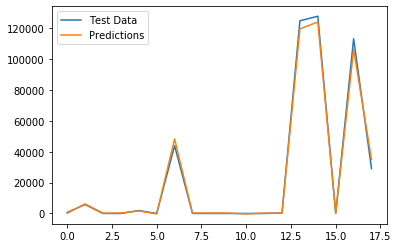

MAE: 1645.0778014765767


In [31]:
country_name = 'Germany'
x_train, x_test, x_pred, y_train, y_test = data_prep(country_name, future_date)
model = pickle.load(open('model/' + country_name + '.pkl', 'rb'))

y_test_pred = model.predict(x_test)
plt.plot(y_test)
plt.plot(y_test_pred)
plt.legend(['Test Data', 'Predictions'])
plt.show()

print('MAE:', mean_absolute_error(y_test_pred, y_test))

## Part 5: Prediction 

In [32]:
directory = 'model'
model_paths = os.listdir(directory)

for path in model_paths:
    country_name = path[:-4]
    model = pickle.load(open(directory + '/' + path, 'rb'))
    if(country_name == 'Taiwan'): country_name = 'Taiwan*'
    x_train, x_test, x_pred, y_train, y_test = data_prep(country_name, future_date)
#     poly_x_pred = poly.fit_transform(x_pred)
    
    y_proj_pred = model.predict(x_pred)
    y_proj_pred = y_proj_pred.astype('int')
    if(country_name == 'Global'): print(y_proj_pred)
    pred_df.loc[country_name, pred_dates] = y_proj_pred
    
pred_df.loc[['Global']]

[    -27     790    1608    2426    3245    4063    4881    5699    7929
   10984   14039   17093   20148   23203   26258   29313   32860   37018
   41176   45334   49492   53344   56971   60598   64225   67853   70606
   72203   73800   75397   76994   78591   80188   81785   83382   84979
   86576   88173   89770   91367   92964   94561   96158   97755   99352
  100949  102546  108246  117480  126714  135948  145182  154416  163649
  179114  198988  218862  238735  268663  304595  340528  376460  418277
  468858  531729  594601  657472  720344  783216  858681  936334 1013986
 1091639 1169292 1246945 1324598 1402251 1484691 1567899 1651106 1734314
 1817522 1900729 1983937 2067145 2150352 2233560 2316768 2399976 2483183
 2566391 2649599 2732806 2816014 2899222 2982429 3065637 3148845 3232052
 3315260 3398468 3481675 3564883]


,01/22/2020,01/23/2020,01/24/2020,01/25/2020,01/26/2020,01/27/2020,01/28/2020,01/29/2020,01/30/2020,01/31/2020,...,04/24/2020,04/25/2020,04/26/2020,04/27/2020,04/28/2020,04/29/2020,04/30/2020,05/01/2020,05/02/2020,05/03/2020
Country/Region,,,,,,,,,,,,,,,,,,,,,
Global,-27,790,1608,2426,3245,4063,4881,5699,7929,10984,...,2816014,2899222,2982429,3065637,3148845,3232052,3315260,3398468,3481675,3564883


In [33]:
pred_df[pred_dates] = pred_df[pred_dates].astype('int')
pred_df[pred_df < 0] = 0

pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, Afghanistan to Zimbabwe
Columns: 103 entries, 01/22/2020 to 05/03/2020
dtypes: int32(103)
memory usage: 81.3+ KB


In [34]:
pred_df.info()
pred_df.to_csv('result/predictions.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, Afghanistan to Zimbabwe
Columns: 103 entries, 01/22/2020 to 05/03/2020
dtypes: int32(103)
memory usage: 81.3+ KB
